# Logistic Regression: Predicting churn with Apache MXNet and Gluon

This notebook is designed to be a quick primer on Apache MXNet and Gluon while solving a churn prediction use case

### Problem

Service providers have historical records on customer loyalty and track how likely users are going to continue to use the service. We can use this historical information to construct a model to predict if the user is going to leave (churn) or continue to use the service.

## Logistic Regression

To solve this problem we are going to use a technique known as logistic regression. Its used when the dependent variable is categorical. In this problem we are predicting if the user will churn or not, hence we'll use a binary logistic regression which is the binary version of the more generalized multiclass logistic regression. For further reading check the wikipedia [article](https://en.wikipedia.org/wiki/Multinomial_logistic_regression)
    
    

## Data

The dataset I use is publicly available and was mentioned in the book “Discovering Knowledge in Data” by Daniel T. Larose. 
It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets, 
and can be downloaded from the author’s website [here](http://www.dataminingconsultant.com/data/churn.txt) in .csv format.

A modified version is provided in the data/ folder for convinience

In [1]:
import numpy as np
import mxnet as mx
import logging
import pandas as pd
import sys
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import logging
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)  # Config the logging

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## Feature selection

There are many factors (or features) that we think are indicative of customer churn. For simplicity we are going to use the last 5 features namely -- Night Charge, Intl Mins, Intl Calls, Intl Charge, CustServ Calls as the indicator for churn.

In [3]:
!head -n 3 churn.txt

### Lets split into training and test set

In [4]:
# Data fields in the CSV

#State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan, VMail Message,Day Mins,Day Calls,
#Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,
#Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?

dataframe = pd.read_csv('churn.txt', engine='python', skipfooter=3)
dataset = dataframe.values
x_data = dataset[:, -6:-1] # use a subset as features

# convert the last field in to [0,1] from False/True 
y_data = np.array([[0 if d == 'False.' else 1 for d in dataset[:, [-1]]]]).T 

print(x_data.shape, y_data.shape)
print(type(x_data), type(y_data))

(3330, 5) (3330, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [5]:
sample_num = x_data.shape[0]
dimension = x_data.shape[1]
batch_size = 32

train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size

train_x, test_x = x_data[0:train_size,:], x_data[train_size:len(x_data),:]
train_y, test_y = y_data[0:train_size,:], y_data[train_size:len(y_data),:]

print(len(train_x), len(test_x))
print(len(train_y), len(test_y))


2331 999
2331 999


Take a moment to look at [NDArrays](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/chapter01_crashcourse/ndarray.ipynb) in MXNet and Gluon. We'll use this extensively in all our notebooks

### Build the Logistic Regression Model -- Symbolic Apache MXNet


In [6]:
# Lets build the Logistic Regression Model

# Placeholders for X & y
data = mx.sym.Variable("data")
target = mx.sym.Variable("target")

fc = mx.sym.FullyConnected(data=data, num_hidden=1, name='fc')
pred = mx.sym.LogisticRegressionOutput(data=fc, label=target)

# Contstruct the module object
model = mx.mod.Module(symbol=pred,
                    data_names=['data'],
                    label_names=['target'],
                    context=mx.cpu(0))

# bind the data and label shapes
# you can also use train_iter.provide_data & .provide_label
model.bind(data_shapes=[mx.io.DataDesc(name='data', shape=(batch_size, dimension), layout='NC')],
         label_shapes=[mx.io.DataDesc(name='target', shape=(batch_size, 1), layout='NC')])
model.init_params(initializer=mx.init.Normal(sigma=0.01))
model.init_optimizer(optimizer='sgd', 
            optimizer_params={'learning_rate': 1E-3, 'momentum': 0.9})

# Build the data iterator
train_iter = mx.io.NDArrayIter(train_x, train_y, batch_size,
                               shuffle=True, label_name='target')


# Create a custom metric
metric = mx.metric.CustomMetric(feval=lambda labels, 
                                pred: ((pred > 0.5) == labels).mean(),
                                name="acc")

# Train the model
model.fit(train_data=train_iter, eval_metric=metric, num_epoch=20)

INFO:root:Epoch[0] Train-acc=0.837757
INFO:root:Epoch[0] Time cost=0.055
INFO:root:Epoch[1] Train-acc=0.864726
INFO:root:Epoch[1] Time cost=0.053
INFO:root:Epoch[2] Train-acc=0.865154
INFO:root:Epoch[2] Time cost=0.050


/opt/dev/environments/project_env/lib/python3.6/site-packages/mxnet/module/base_module.py:502: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)


INFO:root:Epoch[3] Train-acc=0.865154
INFO:root:Epoch[3] Time cost=0.062
INFO:root:Epoch[4] Train-acc=0.865154
INFO:root:Epoch[4] Time cost=0.050
INFO:root:Epoch[5] Train-acc=0.864726
INFO:root:Epoch[5] Time cost=0.050
INFO:root:Epoch[6] Train-acc=0.864726
INFO:root:Epoch[6] Time cost=0.054
INFO:root:Epoch[7] Train-acc=0.864298
INFO:root:Epoch[7] Time cost=0.052
INFO:root:Epoch[8] Train-acc=0.864726
INFO:root:Epoch[8] Time cost=0.054
INFO:root:Epoch[9] Train-acc=0.864726
INFO:root:Epoch[9] Time cost=0.051
INFO:root:Epoch[10] Train-acc=0.864298
INFO:root:Epoch[10] Time cost=0.050
INFO:root:Epoch[11] Train-acc=0.865154
INFO:root:Epoch[11] Time cost=0.056
INFO:root:Epoch[12] Train-acc=0.864298
INFO:root:Epoch[12] Time cost=0.056
INFO:root:Epoch[13] Train-acc=0.866438
INFO:root:Epoch[13] Time cost=0.055
INFO:root:Epoch[14] Train-acc=0.865582
INFO:root:Epoch[14] Time cost=0.055
INFO:root:Epoch[15] Train-acc=0.866866
INFO:root:Epoch[15] Time cost=0.055
INFO:root:Epoch[16] Train-acc=0.865154


## Model Evaluation


In [7]:
# Test data iterator
test_iter = mx.io.NDArrayIter(test_x, test_y, batch_size, shuffle=False, label_name=None)

pred_class = (fc > 0) # de
test_model = mx.mod.Module(symbol=pred_class,
                         data_names=['data'],
                         label_names=None,
                         context=mx.cpu(0))
test_model.bind(data_shapes=[mx.io.DataDesc(name='data', shape=(batch_size, dimension), layout='NC')],
              label_shapes=None,
              for_training=False,
              shared_module=model)
out = test_model.predict(eval_data=test_iter)
acc = np.sum(out.asnumpy() == test_y)/ (len(test_y)*1.0)

#print(out.asnumpy())
print(acc)

0.8328328328328328


## Confusion Matrix

Along with accuracy we'd like to visualize the evaluation with four important statistics relative to the total number of predictions: the percentage of true negatives (TN), true positives (TP), false negatives (FN), and false positives (FP). These stats are often presented in the form of a , as follows.

![.](o_churn_table.png)

In [8]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(test_y, out.asnumpy()))
print(np.sum(test_y))

[[830   0]
 [167   2]]
169


## Logistic Regression with Gluon 

In [9]:
from mxnet import nd, autograd
from mxnet import gluon

ctx = mx.cpu()

N_CLASS = 1

# Define the model
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(1))

# init params
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

# optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})

In [10]:
from mxnet import nd, autograd
from mxnet import gluon

# Define Data Iterators
test_iter = mx.io.NDArrayIter(train_x, train_y, batch_size, shuffle=True, label_name=None)
test_iter = mx.io.NDArrayIter(test_x, test_y, batch_size, shuffle=False, label_name=None)

In [11]:
# The Network

ctx = mx.cpu()
net = gluon.nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=ctx)

In [12]:
#optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})

In [13]:
# loss function

def logistic(z):
    return 1. / (1. + nd.exp(-z))

def log_loss(output, y):
    yhat = logistic(output)
    return  - nd.nansum(  y * nd.log(yhat) + (1-y) * nd.log(1-yhat))

During training we use the autograd module to take gradients. See this [link](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/chapter01_crashcourse/autograd.ipynb) for details on how it works

### Training Loop

In [15]:
epochs = 5
loss_sequence = []
num_examples = len(train_x)
train_iter.reset()
for e in range(epochs):
    cumulative_loss = 0
    for i, batch in enumerate(train_iter):
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = log_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()
    print("Epoch %s, loss: %s" % (e, cumulative_loss ))
    loss_sequence.append(cumulative_loss)

Epoch 0, loss: 1939.530174255371
Epoch 1, loss: 0
Epoch 2, loss: 0
Epoch 3, loss: 0
Epoch 4, loss: 0


DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Text(0, 0.5, 'average loss')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/opt/dev/environments/project_env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0 to DejaVu Sans ('/opt/dev/environments/project_env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


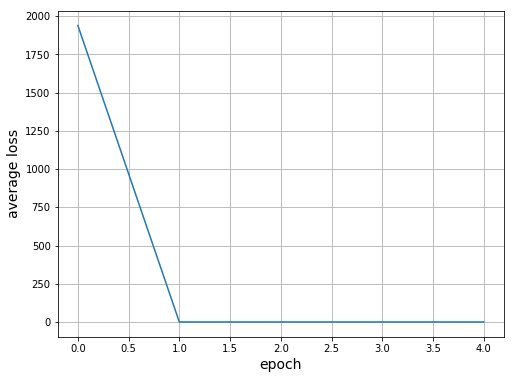

In [16]:
# plot the convergence of the estimated loss function 
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence)

plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

## Calculate the accuracy on the test set

In [17]:
num_correct = 0.0
num_total = len(test_x)
pred_out = []
test_iter.reset()
for i, batch in enumerate(test_iter):
    data = batch.data[0].as_in_context(ctx)
    label = batch.label[0].as_in_context(ctx)
    output = net(data)
    prediction = (nd.sign(output) + 1) / 2
    pred_out.append(prediction.asnumpy())
    num_correct += nd.sum(prediction == label)
print("Accuracy: %0.3f (%s/%s)" % (num_correct.asscalar()/num_total, num_correct.asscalar(), num_total))

Accuracy: 0.851 (850.0/999)


In [18]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(test_y, np.vstack(pred_out)[:len(test_y)]))
print(np.sum(test_y))

[[829   1]
 [169   0]]
169
